<a href="https://colab.research.google.com/github/Buchunwang/UK-CLI/blob/main/k%26N_uk_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**This code is replication of Kim&Nelson (1998) with UK data**
---



---
**Brief introduction of the code:**\
This is a Bayesian algorithm with three main blocks:

1. Kalman filter
2. Hamilton(1989) basic filter
3. Estiamting parameters by multi-move Gibbs sampling.

We iteratively run the process 1→2→3→1→2→3→1…

---



---

The execution of this code takes a few hours, so it is recommended to run it on your own device.

---
---

From the algorithm, we can generate:
1. a new economic index of UK
2. historical recession period of UK
3.In the end, we will also display the distribution of all the parameters.

---

---





**Data**\
First three columns are first order of original UK composite leading indicator(CLI) with 0 lag, 1 lag and 2 lags: $\Delta c_t$, $\Delta c_{t-1}$ , $\Delta c_{t-2}$.\
For column 4:8, they are component variables $\Delta y_i, i=1,2,3,4,5$ applied to generate original CLI.\
 There were 6 component variables in totoal, but we removed new driver number every year as the data is not suitable for this model without etxra modificaions.\
Column 9:13,13:18 are component variables with 1 lag and 2 lags individually:$\Delta y_{i_{t-1}} \& \ \Delta y_{i_{t-2}}, i=1,2,3,4,5$.

All data imported have been detrended.

Name of $Y_i$ :

1. Retail Prices Index - All Items Index
2. Consumer survey - confidence indicator
3.  GBP interbank LIBOR 3 months delayed of UK  
4.  Manufacturing survey - production: future tendency sa (season adjusted)
5.  Share prices: FTSE LOCAL UK ($£ $) index

Data source: OECD

---



---



In [1]:
import os
import pandas as pd
import numpy as np
url = 'https://raw.githubusercontent.com/Buchunwang/UK-CLI/main/Kalman%20filter/kalpre1.csv'
print('From URL:', url)
kalpre1 = pd.read_csv(url, header=None, encoding='utf-8', skiprows=1)

From URL: https://raw.githubusercontent.com/Buchunwang/UK-CLI/main/Kalman%20filter/kalpre1.csv




---


**Model**


---


---

1.
\begin{equation}
\Delta Y_{it}=\lambda_i(L)\Delta C_t+D_i+e_{it} \ \ \ i=1,2,3,4,5 \ \ \ t=1,2… T
\end{equation}
$Y_{it}$ are component series above except passenger car registrations,$C_t$ is the growth rate of CLI,
$\lambda _i(L)=\lambda _i $ here for simplicity.






2.

\begin{equation}
\Psi_i(L)e_{it}=\epsilon_{it},  \ \ \ \epsilon_{it}\sim iid N(0,\sigma_i^2)	  
\end{equation}
where $\Psi_i(L)=1-\psi_{i1}L-\psi_{i2}L^2$, $L$ is the lag operator

3.
\begin{equation}
\Phi(L)(\Delta C_t-\mu_{s_t}-\delta
)=v_t\ \ \ \ \ \ \ \ \ \ v_t\sim iid N(0,1)
\end{equation}
where $\Phi(L)=1-\phi_1L-\phi_2L^2$. $\mu_{s_t}-\delta$ is the mean growth rate of $\Delta C_t$, $\mu_{s_t}$ is the regime-switching component.



4.

\begin{equation}
	\mu_{s_t}=\mu_0+\mu_1S_t
\end{equation}
where $S_t=\{\begin{matrix}
		0,1
	\end{matrix}\}$
 and $\mu_1<0$.
The regime-switching happens at the mean value of $\Delta C_t$.



---


---

We remove the mean value of $\Delta Y_{it}$ and $\Delta C_t$:
\begin{equation}
\Delta c_t=\Delta C_t-\delta
\end{equation}
\begin{equation}
\Delta y_{it}=\Delta Y_{it}-\Delta \overline{Y_i}
\end{equation}

---

Equation 1 and 3 can then be replaced by

5.
\begin{equation}
\Delta y_{it}=\lambda_i(L)\Delta c_t+e_{it} \ \ \ i=1,2,3,4 \ \ \ t=1,2… T
\end{equation}

---



6.


\begin{equation}
\Phi(L)(\Delta c_t-\mu_{s_t}
)=v_t\ \ \ \ \ \ \ \ \ \ v_t\sim iid N(0,1)
\end{equation}


---
---

**Functions**

---


There are 4 functions we are going to use:
1.  Kalman Filter (regime-switching state-space Kalman filter)
2.  Update process afetr Kalman filter using t+1 data for time t
2.  Posterior normal distribution
3.  Posterior inverse Gamma distribution


Function 1: regime-switching Kalman filter\
input:
1.  parameters generated from last step's multimove Gibbd sampling
including $\Phi(L), \Psi_i(L), \mu_0,\mu_1,\sigma_i, \lambda_i(L), i= 1,2,3,4$
2.  series $\Delta y_{it} , i=1,2,3,4$

output:
1. mean & variance of $\Delta \zeta_{t|t} , t=1, ⋯⋯, T-1, T$
2. steady-state Kalman gain


---
\begin{equation}
	\Delta y^*_t=H^*\zeta_t+\epsilon_t
\end{equation}
\begin{equation}
	\zeta_t=\tilde M^*_{s_t}+F^*\zeta_{t-1}+u^*_t
\end{equation}

---
For the fuction, we have 9 input:
1. N: length of input data
2. true4D: the input time series data with 4 dimension, which is $\Delta y^*_t$ in above equation
3. R: measurement noise covariance martix with variance of $\epsilon_{it}$ on the diagonal
$R=\begin{bmatrix}
\sigma^2_1&0&0&0&0\\
0&\sigma^2_2&0&0&0\\
0&0& \sigma^2_3&0&0\\
0&0&0&\sigma^2_4&0\\0
&0&0&0&\sigma^2_5
\end{bmatrix}
$
4. Q_kal: the covariance matrix of $u^*_t$, the size of Q_kal depends on the length of vector $\zeta_t$. if $\zeta_t$ is a vector with k columns, then size of Q_kal is $k\times k$.
5. P: the covariance of $\zeta_t$. P is updated during the process. We can initialize P as an identity matrix or a zero matrix; alternatively, we can choose a more appropriate initialization to provide the Kalman filter with a better prior.
6. H: measurement matrix. It maps the state variables into the measured outputs.
7. A (or F in the equation above): state transition matrix, it connects the two vector by $\xi_t=F^*\zeta_{t-1}+Q_{kal}$
8. K: Kalman gain, this is just initialization, K would get updated in the process. We can set K as a zeros matrix with the same size as H.T (transposed H)
9. Mu_st: vector of state-dependent element, correspondent with $\tilde M^*_{s_t}$ in the equation

About $\zeta_t$: This is unknown. Mean and variance of $\xi_t$ is what we are going to estimate through Kalman filter.

Also: not all element inside the $\xi_t$ are going to be used in the whole iteration. $\xi_t$ might be a vector such as $\zeta_t=\begin{bmatrix}
	\Delta c_t\\ \Delta c_{t-1} \\ \Delta c_{t-2}
\end{bmatrix}$, but in the end we only need $\Delta c_t$ which is the first element. This will be given more detailed explainations in the full algorithm part with examples.

Before running Kalman filter, we should also prepare empty matrix to save the output which is the mean and variance of $\zeta_t$ ( or some specific rows of $\zeta_t$).


---
Kalman filter has 5 equations: First 2 equations are called the process of predicting, later 3 equations are called the proecess of filtering or correction.

Initial values are required for the first iteration of kalman filter. For the first input $t=1$, we assume mean value $\zeta_{1|1}=0$ and variance $P_{1|1}$ be a diagonal matrix with 0.1 on the diagonals. Choice of initial value depends on the user but it would be better to set some reasonable initial. Very wrong initialization could cause trouble for other blocks of the MCMC algorithm in actual tests.


t iterates from t=2 to t=T, we should provide the

For each iteration t, we use t-1 as input. $\zeta_{t|t}$ from last iteration would become $\zeta_{t-1|t-1}$ for next iteration. $P_{t|t}$ from last iteration would become $P_{t-1|t-1}$ for next iteration.

---

Kalman equation 1:
\begin{equation}
 \zeta_{t|t-1}=F^*\zeta_{t-1|t-1}+\tilde M^*_{s_t}
 \end{equation}
 Equation 1 is the process of **predicting** mean value of $\zeta_t $ from $\zeta_{t-1}$.  $\  \zeta_{t|t-1}=E[\zeta_t|t-1]=E[F*\zeta_{t-1}+\phi(L)\mu_{st}+v_t|t-1]=F*\zeta_{t-1}$ as $\mu_{st}$ is imposed mean zero in the setting according to Kim and Nelson (1998) and $v_t$ is iid noise of time t.

   This is extended version of normal state-space Kalman filter as we added state-dependent element $M_{st}$ in the first kalman filter equation. For normal kalman filter, first Kalman equation is $\zeta_{t|t-1}=F^*\zeta_{t-1|t-1}$.

---  
Kalman equation 2:
 \begin{equation}
 P_{t|t-1}=F^*P_{t-1|t-1}F^{*^T}+Q
 \end{equation}
 Equation 2 is the process of **predicting** variance of $\zeta_t $ from $\zeta_{t-1}$. $Q$ is the variance matrix of process noise $[v_t,\ v_{t-1},\ 0]'$.  

---
Kalman equation 3:
\begin{equation}
	K(t)= P_{t|t-1}H^{*^T}[H^*P_{t|t-1}H^{*^T}+R]^{-1}      
\end{equation}
Equation 3 is the process of **filtering** or upgrading. Through this equation we can obtain the value of Kalman gain $K$. Kalman gain would stablize after a few iterations (which is called as steady-state Kalman gain). This is caused by the stablized variance matrix $P$ after a few iterations.
  
---
Kalman equation 4:
\begin{equation}
 \zeta_{t|t}= \zeta_{t|t-1}+K(t)([\Delta y^*_t-H^*\zeta_{t|t-1}]
\end{equation}
Equation 4 is the process of **filtering** mean value of $\zeta_t$ by adding the filtered error term at time t.
  
---
Kalman equation 5:
\begin{equation}
	P_{t|t}=[I-K(t)H^*]P_{t|t-1}
\end{equation}
where $I$ is identity matrix.  
Equation 5 is the process of **filtering** variance of $\zeta_t$. $P$ would stablize with the stablization of Kalman gain after a few iterations.
  





---
---
Function 2: the process of adding t+1 data to the information set after running kalman filter

This process is from step 2 of appedix A1 in Kim $\&$ Nelson (1998). After running the Kalman filter to generate mean and variance of $\Delta c_t$ conditional on t, which is $\Delta c_{t|t}$, Kim applied t+1 data to update the mean & variance of $\Delta c_{t|t}$.

Reason for using t+1 data to improve estimation:
1.  From information set side, for data at time t, as Kalman filter is a forward iteration, data from 1 to t-1 are already in the information set for $\Delta c_{t|t}$. If we want something new, some extra information, it's only available from the rightside of t: t+1...,T-1,T. Considering t+1 data is known from Kalman filter, we can now treat t+1 data as observations.
2.  From Kalman filter side, kalman filter would smooth the series and reduce the noise, but at the same time, kalman filter would make the series generated from $\Delta y^*_t$ less informative. This might be kind of vague, one example is: If we don't do this process after the Kalman filter, the sharp decrease in index caused by great recession (such as 2008, 2020) would get smoothed by Kalman filter. It would make 2008 or 2020 look like relatively mild recessions which is not proper. This 't+1' process can effectively bring back the useful information (such as strength of recession) to the generated series $\Delta c_t$.
3.  In terms of final effect, the variance of each data point of $\Delta c_t$ would decrease after this process because the whole system gets more informative after including t+1 data as extra observations into information set. The final sample of $\Delta c_{t|t+1}$ generated from new mean and variance would be less noisy compared with $\Delta c_{t|t}$ generated from former mean and variance.

---
Reference for this updating process:chapter 13.6 http://mayoral.iae-csic.org/timeseries2021/hamilton.pdf  or see step2 of appendix A2 from Kim and Nelson (1998)

---
Update equations:
\begin{equation}
	\zeta_{t|t,\Delta c_{t+1}}=\zeta_{t|t}+V_{t|t}F^*(1)\eta_t/R_t
\end{equation}  

\begin{equation}
	V_{t|t,\Delta c_{t+1}}=V_{t|t}-V_{t|t}F^*(1)F^*(1)'V_{t|t}'/R_t
\end{equation}

where $\eta_t=\Delta c_{t+1}-\Phi(L)\mu_{t+1}-F^*(1)\zeta_{t|t}$ and $R_t=F^*(1)V_{t|t}F^*(1)'+var[u^*_{t+1}(1)]$. $F^*(1)$ and $u^*_{t+1}(1)$ are first row of $F^*$ and $u^*_{t+1}$.
$ F^* =\begin{bmatrix}
		\phi_1 & \phi_2 & 0  \\
1 & 0 & 0\\
0 & 1 & 0
	\end{bmatrix}
$, so $F^*(1)=\begin{bmatrix}
		\phi_1 & \phi_2 & 0
   \end{bmatrix}$
       
       
$\zeta_{t|t}=\begin{bmatrix}
	\Delta c_t\\ \Delta c_{t-1} \\ \Delta c_{t-2}
\end{bmatrix}$
$
V_{t|t}=\begin{bmatrix}
	Var(\Delta c_t)\\ Var(\Delta c_{t-1}) \\ Var(\Delta c_{t-2})
\end{bmatrix}
$
$var[u^*_{t+1}(1)]=var(v_{t+1})=1$ as $v_t\sim iid N(0,1)$




---
---

Function 3:calculating posterior mean & variance for normal distribution

---
Input:
prior mean & variance (fixed during the whole process of MCMC)
a & b: these two depends on the specific setting of each parameter

Output:
posterior mean & variance of the parameter

---
posterior mean = ((prior var$)^{-1}$+a$)^{-1}* $ ((prior var$)^{-1}*$ (prior mean) + b )

posterior var  = ((prior var$)^{-1}$+a$)^{-1}$

---
In the code, we have written separate sections for computing the mean and variance, both in scalar and matrix form. The mathematical operations remain the same, but for the matrix form, we employ an inverse matrix function which is not applicable to scalars (as the code for the inverse function does not accommodate scalars in Python).

---
---
 Function 4: generating sample of variance from posterior inverse distribution

---
Input: a & b

a is Shape Parameter : It influences the shape of the distribution. Higher values of a will make the distribution peak more to the right of the origin, concentrating more probability mass on higher values.

b is Scale Parameter: It is a positive scalar that stretches or shrinks the distribution along the x-axis. Larger values of b will spread the distribution out, placing more probability mass over a wider range of values.

Here our input a & b are posterior for inverse gamma distribution.

Output: Variance samples generated from the posterior inverse gamma distribution:In the implementation, if we opt to use the gamma distribution to generate random samples, the function should be represented as $ 1/\text{IG}(a1, 1/b1) $ for $ \sigma^2 \sim \text{IG}(a1,b1) $. Alternatively, we can utilize the inverse gamma function from the scipy package, with the code being invgamma.rvs(a,b).



In [2]:
import numpy as np
from scipy.stats import norm, gamma, beta
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from numpy.random import normal
import pandas as pd
import warnings
def Kalman(R,H,A,Q_kal,true5D,Mu_st,N,P,K):
# Function 1. Kalman filter (regime-switching)
    k = 0
    for t in range(N-1):
        k += 1
        x[:, k] = np.dot(A, x[:, k-1])+Mu_st[:,k]                                 # Kalman equation 1, Mu_st is the vector with state-dependent element
        P = np.dot(A, np.dot(P, A.T)) +Q_kal                                      # Kalman equation 2
        K = np.dot(P, np.dot(H.T, np.linalg.inv(np.dot(H, np.dot(P, H.T)) + R)))  # Kalman equation 3
        x[:, k] = x[:, k] + np.dot(K, (true5D[:, k] - np.dot(H, x[:, k])))        # Kalman equation 4
        P = np.dot((np.eye(P.shape[0]) - np.dot(K, H)), P)                        # Kalman equation 5
        vct[0, k] = P[0, 0]  # save variance of delta_ct
    return K, x, vct

# Function 2. the process of adding t+1 data to the information set after running kalman filter
# From this process, we will obtain mean & variance of delta c_{t|t+1}
# The order of updating is backward, using data from T to update T-1 data,then update T-2...,3,2,1

def afterkal(x,vct,Q_kal,phi,c):# add t+1 data to information set
    for ii in range(N-2):       # this loop is just for xi_t and V_t conditional on delta_ct+1 for t=1,2,...,T-1
        eta = c - phi[0]*x[0, N-ii-2] - phi[1]*x[0, N-ii-3] - phimu_st[N-ii-1]  # first input c is delta c_{T|T}
                                                                                # start from 2nd iteration
                                                                                # c is delta c_{t|t+1})
        Rt = phi[0]**2*vct[0, N-ii-2]+phi[1]**2*vct[0,N-ii-3]+var_vt
        xi[0, N-ii-2] = x[0, N-ii-2] + (phi[0]*vct[0, N-ii-2]+phi[1]*vct[0,N-ii-3])*eta/Rt
        # we only use first row of the mean and variance vector
        # so I calculated the first element of each mean & variance directly
        V[0, N-ii-2] = vct[0, N-ii-2] - (phi[0]**2 * (vct[0,N-ii-2]**2)+phi[1]**2*(vct[0,N-ii-3]**2)) / Rt
        c = normal(xi[0, N-ii-2], np.sqrt(V[0, N-ii-2]))
    V[0, N-1] = vct[0, N-1] # V_T didn't get upgraded, it's still from step 1
    xi[0, N-1] = x[0, N-1]  # xi_T didn't get upgraded, it's still from step 1
    return xi,V

# Function 3. calculating posterior mean & variance for normal distribution
def posteriornormal(mean,var,a,b):

    if np.isscalar(mean) and np.isscalar(var):
        mean = 1/(1/var+a) * (mean/var + b )
        var  = 1/(1/var+a)

    else:
        mean = np.linalg.inv(np.linalg.inv(var)+a) @ (np.linalg.inv(var) @ mean + b )
        var  = np.linalg.inv(np.linalg.inv(var)+a)
    if np.isnan(mean).any(): # if NaN shows up,reset to initial value
        mean = np.zeros(mean.shape)
        var = np.eye(var.shape[0])
    return mean, var


# Function 4. Generating random sample for posterior inverse gamma distribution
def posteriorIG(a,b):
    #input a,b here are posterior values
    sig=1 / np.random.gamma(a, 1/b)
    return(sig)

In [5]:
##########################################################################
#          pre-setting
##########################################################################
import numpy as np
from scipy.stats import norm, gamma, beta
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from numpy.random import normal
import pandas as pd
import warnings
# Remove warning message of time series from each iteration
def custom_warning_handler(*args, **kwargs):
    pass

warnings.showwarning = custom_warning_handler

##########################################################################
#          iteration setting
##########################################################################
iter = 10000 # number of iterations
burn = 2000  # we burn the first 2000 iterations and sampling from the later 8000 iterations in the MCMC
             # If we find the samples still can't converge after 2000 iterations,
             # burn and whole iteration number can be modified.
             # Another common choice is iteration 20000 times and burn the first 10000 iterations.

             # A higher number of burns would make the results more stable & convincing
             # but it would also make the program much slower

##########################################################################
#          input data
##########################################################################
delta_y_mean = np.zeros((5,1))
for i in range(5):
    delta_y_mean[i,0] = np.mean(kalpre1.iloc[:, i + 2]) # mean value of Y_it
                                                        # This will be used in generating delta in appendix 7
scale= StandardScaler()
kalpre = scale.fit_transform(kalpre1)#standardize data

np.random.seed(6)              # fix randomness
N = kalpre.shape[0]            # length of input
Y = np.transpose(kalpre[:,3:8])# Y_{1t} to Y_{5t}
                               # Calculate delta_y, delta_y_t-1, and delta_y_t-2
                               # Yit-E(Y), remove the mean value
y = np.zeros((5, N))
y1lag = np.zeros((5, N))
y2lag = np.zeros((5, N))

for i in range(5):
    y[i, :] = kalpre[:, i + 2] - np.mean(kalpre[:, i + 2])
    y1lag[i, :] = kalpre[:, i + 7] - np.mean(kalpre[:, i + 7])
    y2lag[i, :] = kalpre[:, i + 12] - np.mean(kalpre[:, i + 12])


##########################################################################
# storage space for kalman filter output
##########################################################################
x = np.zeros((3, N))           # empty matrix to save mean value of xi_t
xi=np.zeros((1,N))             # mean of delta c_{t|t+1}
V=np.zeros((1,N))              # variance of delta c_{t|t+1}
mu_st=np.zeros(N)              # regime-switching element mu_st
phimu_st=np.zeros(N)           # regime-switching element with lags for kalman filter: phi(L)*mu_st,
                               # phimu_st is input for Kalman filter equation 1
new_delta_ct= np.zeros((N, 1)) # delta c_{t|t+1}


# Form noise matrix Q_kal, correpodent with vector u^*_t=[var_vt 0 0 0 0 0]'
var_vt=1                       # iid variance in equation (3), vt~iid N(0,1)
                               # scale of new economic index is up to the choice of v_t's variance


##########################################################################
# Gibbs sampling
##########################################################################
Nn=kalpre.shape[0]-2            # length of input for Gibbs sampling
rrighta3 = np.zeros((1, Nn - 2))# this matrix is for calculating distribution of lamda
Q = np.zeros((Nn - 4, 2))
Qstar = np.zeros((Nn - 4, 2))
fvarphi = np.array([[1, 0], [0, 1]])
mut = np.zeros(Nn)              #corresponding regime for t=3 to N, this is for estimating parameters
meanlamda=np.zeros(5)
varlamda=np.zeros(5)
lamda=np.zeros(5)
sig=np.zeros(5)

# Initialize the DataFrame with the size of 8x419 with NaNs
inputkal1 = np.full((Nn,8), np.nan)
# Fill the columns 4 to 8 with the data from 'kalpre'
inputkal1[:,3:8] = (y[:,2:N]).T # Nn = N-2


##########################################################################
# user-choose prior
##########################################################################
# variance and mean prior
varlamdap=1
meanlamdap=0
varpsip = np.eye(2)
meanpsip = np.zeros((2, 1))
sig_a=(Nn-2)/2                 # when calculating sigma, length of applied series is Nn-2
                               # sigma_1~IG(sig1a,sig1b) inverse gamma distribution
                               # prior is IG(0,0),
                               # because posterior is a fixed number : shape parameter prior+T/2 which is just T/2,
                               # so we just set sig_i_a as (Nn-2)/2 here
                               # T is the lenth of input series, here the length is Nn-2
                               # if want different prior such as m, let sig1a=...=sig5a=m+T/2
varmup=varphip = np.eye(2)
meanmup=meanphip = np.zeros((2,1))


##########################################################################
# form storage space
##########################################################################
# We set some empty matrices here to save values from each iteration
# After the 2000 burn-in period, we need to save value for later 80000 iterations
vlamda=np.zeros((iter-burn,5))
mlamda=np.zeros((iter-burn,5))
bsig=np.zeros((iter-burn,5))
vpsi=np.zeros((iter-burn,10))
mpsi=np.zeros((iter-burn,10))
mphi=np.zeros((iter-burn,2))
vphi=np.zeros((iter-burn,2))
mmu=np.zeros((iter-burn,2))
vmu=np.zeros((iter-burn,2))
mmu1 = np.zeros(iter-burn)
mmu2 = np.zeros(iter-burn)
vmu1 = np.zeros(iter-burn)
vmu2 = np.zeros(iter-burn)
delta=np.zeros(iter-burn)
transition_prob_p=np.zeros(iter-burn)
transition_prob_q=np.zeros(iter-burn)
delta=np.zeros(iter-burn)
regime=np.zeros((N-2, 1))
e_it=np.zeros((5,N)) # for e_it i=1,2,3,4,5 (it's used when calculating delta)
sample_ct=np.zeros((N, 1))



##########################################################################
# Initialization
##########################################################################
q = 0.9 # transition probability, recession to recession: q = P(S_t=0|S_t-1=0)
p = 0.9 # transition probability, expansion to expansion: p = P(S_t=1|S_t-1=1)
lamda=0.5*np.ones(5)
sig=0.2*np.ones(5)
psi=np.zeros((5,2))
phi=np.zeros(2)
mu0=-2
mu1=2.5


##################################  generate initial St based on transition probabilties p,q
def generate_markov_chain(p, q, initial_state, N):
    # Initialize the Markov Chain
    markov_chain = np.zeros(N)
    markov_chain[0] = initial_state

    for i in range(1, N):
        if markov_chain[i-1] == 1:
            markov_chain[i] = np.random.choice([0, 1], p=[1-p, p])
        else:
            markov_chain[i] = np.random.choice([0, 1], p=[q, 1-q])

    return markov_chain
initial_state = 1  # initial state
St = generate_markov_chain(p, q, initial_state, N)
SSt=St
mu_st = mu0 * np.ones(N) + mu1 * np.ones(N) * St
phimu_st = (np.array(mu_st[2:N])
            - np.array(mu_st[1:N-1]* phi[0])
            - np.array(mu_st[0:N-2]* phi[1]))
phimu_st = (np.array(mu_st[2:N])
            - np.array(mu_st[1:N-1]* phi[0])
            - np.array(mu_st[0:N-2]* phi[1]))
phimu_st = np.array(phimu_st)
phimu_st = np.insert(phimu_st, [0, 0], phimu_st[0])# As Phi(L)*mu_st has two lags
                                                   # there will be 2 data loss at the beginning
                                                   # we fill those two data points by 0
                                                   # so for beginning two points of kalman filter
                                                   # We run the Kalman filter as non-regime-switching Kalman filter
                                                   # as regime-switching element Phi(L)*mu_st=0
Mu_st=np.zeros((3,N))
Mu_st[0,:]=phimu_st                                # form M^{~*}_{st}to fit the input size of kalman filter
                                                   # other parts are just 0s


##############################################################################
# initial setting finishes here
##############################################################################

**Details of the algorithm**

---


---


---




In Gibbs sampling, we always use the most up-to-date information as input for each block of the Bayesian algorithm.

There are 3 main blocks: Kalman filter, Hamilton (1989) basic filter and paraeter estimation through multimove Gibbs sampling. We will introduce detail of each block and how to iteratively connect each block.


---


---


First step: Kalman filter\
input:
1.  parameters generated from last step's multimove Gibbd sampling
including $\Phi(L), \Psi_i(L), \mu_0,\mu_1,σ_i λ_i, i= 1,2,3,4,5$
2.  series $Δ y_{it}, i=1,2,3,4,5$

output: mean & variance of $Δ c_{t|t} , t=1, ⋯⋯, T-1, T$

Then we make use of t+1 data of $Δ c_{t|t}$ to update $Δ c_{t|t}$ based on Kalman filter equations

In the end of step 1: we get $Δ c_{t|t+1}$

---
\begin{equation}
	\Delta y^*_t=H^*\zeta_t+\epsilon_t
\end{equation}
\begin{equation}
	\zeta_t=\tilde M^*_{s_t}+F^*\zeta_{t-1}+u^*_t
\end{equation}
which can be expanded as  

\begin{equation}
\begin{bmatrix}
	\Delta y^*_{1t}\\ \Delta y^*_{2t}\\ \Delta y^*_{3t}\\ \Delta y^*_{4t}\\ \Delta y^*_{5t}
\end{bmatrix}
=
\begin{bmatrix}
	\lambda_1&\ \  -\lambda_i\psi_{11}&\ \ -\lambda\psi_{12}\\
	\lambda_2&\ \ -\lambda_i\psi_{21}&\ \ -\lambda\psi_{22}\\
	\lambda_3&\ \ -\lambda_i\psi_{31}&\ \ -\lambda\psi_{32}\\
	\lambda_4&\ \ -\lambda_i\psi_{41}&\ \ -\lambda\psi_{42}\\
	\lambda_5&\ \ -\lambda_i\psi_{51}&\ \ -\lambda\psi_{52}\\
\end{bmatrix}
\begin{bmatrix}
	\Delta c_t\\ \Delta c_{t-1} \\ \Delta c_{t-2}
\end{bmatrix}
+
\begin{bmatrix}
	\epsilon_{1t}\\
	\epsilon_{2t}\\
	\epsilon_{3t}\\
	\epsilon_{4t}\\
	\epsilon_{5t}\\
\end{bmatrix}
\end{equation}
\begin{equation}
	\begin{bmatrix}
\Delta c_t\\ \Delta c_{t-1} \\ \Delta c_{t-2}
	\end{bmatrix}
	=
	\begin{bmatrix}
		\Phi(L)\mu_{s_t}\\
		0\\
		0
	\end{bmatrix}
	+\begin{bmatrix}
		\phi_1&\phi_2 & 0\\
		1&0&0\\
		0&1&0
	\end{bmatrix}
	\begin{bmatrix}
	\Delta c_{t-1}\\ \Delta c_{t-2} \\ \Delta c_{t-3}
	\end{bmatrix}
	+
	\begin{bmatrix}
		v_t\\ 0 \\ 0
	\end{bmatrix}
\end{equation}

Before starting Kalman filter, we form all the matrix above. Also, $Δ y^*_{it}=\Psi_i(L)*Δ y_{it}$, we use new $\Psi_i(L)$ estimated from last iteration to form new $Δ y^*_{it}$ at the beginning of Kalman filter in every iteration.

---



The function of Kalman filter is to estimate mean and variance of $\zeta_t$, $\zeta_t=	\begin{bmatrix}
\Delta c_t\\ \Delta c_{t-1} \\ \Delta c_{t-2}
	\end{bmatrix} $.  

Algorithm of Kalman filter is show as follows

t iterates from t=2 to t=T

For each iteration t, we use t-1 as input. $\zeta_{t|t}$ from last iteration would become $\zeta_{t-1|t-1}$ for next iteration. $P_{t|t}$ from last iteration would become $P_{t-1|t-1}$ for next iteration.

1.
\begin{equation}
 \zeta_{t|t-1}=F^*\zeta_{t-1|t-1}+\tilde M^*_{s_t}
 \end{equation}
 Equation 1 is the process of **predicting** mean value of $\zeta_t $ from $\zeta_{t-1}$.  $\  \zeta_{t|t-1}=E[\zeta_t|t-1]=E[F*\zeta_{t-1}+\phi(L)\mu_{st}+v_t|t-1]=F*\zeta_{t-1}$ as $\mu_{st}$ is imposed mean zero in the setting according to Kim and Nelson (1998) and $v_t$ is iid noise of time t. For the first input $t=1$, we assume $\zeta_{1|1}=0$. This is extended version of normal state-space Kalman filter as we added state-dependent element $M_{st}$ in the first kalman filter equation.
   
2.
 \begin{equation}
 P_{t|t-1}=F^*P_{t-1|t-1}F^{*^T}+Q
 \end{equation}
 Equation 2 is the process of **predicting** variance of $\zeta_t $ from $\zeta_{t-1}$. $Q$ is the variance matrix of process noise $[v_t,\ v_{t-1},\ 0]'$.  

 3.
\begin{equation}
	K(t)= P_{t|t-1}H^{*^T}[H^*P_{t|t-1}H^{*^T}+R]^{-1}      
\end{equation}
Equation 3 is the process of **filtering** or upgrading. Through this equation we can obtain the value of Kalman gain $K$. Kalman gain would stablize after a few iterations (which is called as steady-state Kalman gain). This is caused by the stablized variance matrix $P$ after a few iterations.
  

4.
\begin{equation}
 \zeta_{t|t}= \zeta_{t|t-1}+K(t)([\Delta y^*_t-H^*\zeta_{t|t-1}]
\end{equation}
Equation 4 is the process of **filtering** mean value of $\zeta_t$ by adding the filtered error term at time t.
  

5.
\begin{equation}
	P_{t|t}=[I-K(t)H^*]P_{t|t-1}
\end{equation}
where $I$ is identity matrix.  
Equation 5 is the process of **filtering** variance of $\zeta_t$. $P$ would stablize with the stablization of Kalman gain after a few iterations.
  

---


We iteratively run the algorithm from equation 1 to 5 from $t=2$ to $t=N$ and in the end we would obtain the filtered mean and variance of $Δ c_{t|t}$ for $t=1\dots N$ from each iteration.

After Kalman filter, we make full use of the information to improve the estimation result of Kalman filter.

 Take $\Delta\ c_{t+1}$ as observation and run a backward iteration to improve the effect of estimation.

---

We take $\Delta c_{t+1}$ as extra observation and add  it to information set to lower the variance based on the following equation:
\begin{equation}
	p(\tilde{\zeta}_T|\Delta\tilde{y}^*_T)=p(\zeta_T|\Delta\tilde{y}^*_T)\mathop{\Pi}\limits^{T-1}_{t=1}p(\zeta _t|\Delta\tilde{y}^*_t,\zeta _{t+1})
\end{equation}
where joint distribution $\tilde{\zeta}_T=[\begin{matrix}
	\zeta_1 &\zeta_2& \cdots &\zeta_T
\end{matrix}]$' and $\tilde{y}_T=[\begin{matrix}
	y_1 &y_2& \cdots &y_T
\end{matrix}]$'.
\\ From last step, $\zeta _{t|t}$ and $V_{t|t}$ is obtained and we generated $\Delta c_T$. In this step, $\Delta c_t$ for $t=1,2,\cdots T-1$ is what we are going to generate. We follow \citet{kim} and chapter 13 of \citet{ham2}, the updating equations of adding $\Delta c_{t+1}$ into information set are:  

\begin{equation}
	\zeta_{t|t,\Delta c_{t+1}}=\zeta_{t|t}+V_{t|t}F^*(1)\eta_t/R_t
\end{equation}  

\begin{equation}
	V_{t|t,\Delta c_{t+1}}=V_{t|t}-V_{t|t}F^*(1)F^*(1)'V_{t|t}'/R_t
\end{equation}  

where $\eta_t=\Delta c_{t+1}-\Phi(L)\mu_{t+1}-F^*(1)\zeta_{t|t}$ and $E_t=F^*(1)V_{t|t}F^*(1)'+var[u^*_{t+1}(1)]$. $F^*(1)$ and $u^*_{t+1}(1)$ are first row of $F^*$ and $u^*_{t+1}$.
  
  With the new mean $\zeta_{t|t,\Delta c_{t+1}}$ and variance $V_{t|t,\Delta c_{t+1}}$ conditional on $\Delta c_{t+1}$, we can generate $\Delta c_t$ for $t=1,2,\cdots T-1$, we have also got $\Delta c_T$ from last step. In the end, we get $\Delta c_{t|t+1}$ for $t=1,2,\cdots T$



---

---

 **Second step: Hamilton (1989) basic filter**

Here we applied MarkovAutoregression package in python. There is prepared Hamilton filter inside the package.
We could also use Markovregression package which will be 10 times faster but we will miss many small recessions if we choose this package. It's fast but not informative.

Input: series $\Delta c_{t|t+1}$ from Kalman filter




Setting of Hamilton filter:
1.  regime number:2
2.  order of autoregression:4 (this could be different for different data) If we don't set order of autoregression properly, there could be two consequences: 1. improper etimation regime probabilities 2. the worst case is that hamilton filter would collapse (happened in actual tests). Hamilton filter can't generate regime probabilties (or just P($recession_t$) is a stochastic process around 0.5, meaningless estiamtion. For UK data, order=2 is the appropriate choice.


Output:
1. regime probabilities of recession $\&$ expansion at each time t
2. steady state transition probabilities between regimes
3. regime series (if at time t, $P(recession)>P(expansion), S_t=0,$ otherwise $S_t=1$

After Hamilton basic filter, there is one extra smooth process based on Bayes rule in Kim & Nelson (1998), this is also covered in the MarkovAutoregression package. We don't need to write extra code on this.

Hamilton(1989) filter is critial part for this 'regime-switching' algorithm as it exposes the recession/expansion information from input data.

One thing needs extra attention is that Hamilton(1989) basic filter can't handle extreme values. The program would collapse if extreme value shows up. There are a few things we can do if this happens.
1.  Modify regime numbers. We can try giving extreme situation another indepednt regime. For example, current nodel here uses 2-regime setting, we could try 3 regimes.
2.  Apply smoothers to the input data, actually kalman filter/ Kalman smoother has smoothed the data but in our algorithm, we applied the process of using t+1 data to improve estimation after running kalman filter. The good side is this will make input series more informative but the bad side is the new series generated after using t+1 data will break the smooth effect at the same time. So when you face the situation of extreme values, there are two options: smoothed but less informative data or informative data but there are extreme values.
3.  Remove the process of using t+1 data after kalman filter. This process would make the input $\Delta c_t$ more informative but this process can also lead to the existence of extreme values at the same time. Extreme value could cause the collapse of Hamilton (1989) basic filter. Point 2 $\&$ 3 are talking about similar situation, the process of applying t+1 data is the source of this algorithm, we remove this process or we give extra smooth ( if the Hamilton filter collapses).
4.  Romove the most unstable data period (such as 2020 recession in UK data test). Without this period, it's much easier for Hamilton basic filter to work. By the way, if we romove a period of extreme value, the generated recession probability series can be very different according to the actual tests. Very different probability series doesn't mean it's wrong. It's just because information we provided for this ML method gets very different, then the algorithm would tell us a new result based on this new series. The difference is: In former series, we can only see signals of very strong recession, probabilities of normal recession would only be about 0.1, 0.2, but we are expecting it to be over 0.5 as they are also real recessions. If we remove the most strong extreme values, the etimation for these common or weak recession would look better. Consequently, the effect of etimation normal time would be better and more reasonable. But we do care more about those extreme recessions rather than mild ones. For forecast or estimation of normal period, including extreme value would reduce the effictiveness but this may not be an appropriate choice for study of originally unstable stuff such as volatilities and study of exploring recession period/signals like what we are doing.
5. We are also looking for a better algorithm that can fulfill the regime-switching related function and can handle extreme value at the same time (something better than Hamilton filter) but haven't find a good one.  

Some extra setting after the Hamilton filter:

As we set autoregression order=4, there are only N-4 data as output. The 4 missing data point at the beggining of series, we set them all as 1 according to kim's code. So the output St series are: [1,1,1,1, St]\
Would this affect estimation results? Very small influence. 1. For parameter estimation after hamilton filter, we use N-2 data, so only first 2 data are affected by our setting. 2. For Kalman filter, prediction and filtering part of Kalman filter is not accurate at the beginning part, the variance would stablize at around t=10. What's more, after running the code for the first time, we can modify the frist 4 St according to the estimation result of the model (such as [1 0 0 0 St] or [0 1 1 0 St], this would minimize the negative influence.



---

---

**Third step: parameter estimation**

input: $Δ y_{it}$, $Δ c_t$, $S_t$, prior distribution of each parameter

output: posterior distribution of each parameter.

---
Prior distributions for each parameter stay fixed during the process of MCMC.

The equation of posterior distribution is calculated through MLE.

In each calclulation of posterior distribution, we always use the most up-to-date copy of input.

---




 Generating $\lambda _i$, $i=1,2,3,4,5$
Given $\tilde{S}_T=\begin{bmatrix}
	S_1& S_2 &\cdots&S_T
\end{bmatrix}'$ from last step and $\tilde{c}_T=\begin{bmatrix}
	c_1& c_2 &\cdots&c_T
\end{bmatrix}'$.

\begin{equation}
	y^*_{it}=\lambda_i\Delta c_t^*+\epsilon _{it}
\end{equation}
where $\Delta c^*_t=\Psi_i(L)\Delta c_t$ and $\Delta y^*_t=\Psi_i(L)\Delta y_t$. $Ψ_i(L)$ we use in one iteration is the most up-to-date sample generated from last iteration. Define $\Delta \tilde{C}^*$ and $\Delta \tilde{y}^*_i$ as variable vectors of right-hand-side and left-hand-side individually. We can then generate posterior distribution $\lambda_i$ by:


$$
\lambda_i \sim N\left(\left(\sigma_i^{-2} \Delta\tilde{C}^{\prime} \Delta\tilde{C}^{\ast} + X_i^{-1}\right)^{-1}\left(\sigma_i^{-2} \Delta\tilde{C}^{\prime} \Delta\tilde{y}_i^{\ast} + X_i^{-1} x_i\right), \left(\sigma_i^{-2} \Delta\tilde{C}^{\prime} \Delta\tilde{C}^{\ast} + X_i^{-1}\right)^{-1}\right)
$$

given prior distribution as
\begin{equation}
	\lambda_i\sim N(x_i,X_i)
\end{equation}

$σ_i$ used in current iteration is sample generated from last itereation.

---


 Generating $\psi$ and $\sigma_i$, $i=1,2,3,4,5$
Let $Z_t=y_{it}-\lambda _i \Delta c_t=e_{it}$ where $\lambda _i$ is newly generated from last step.

\begin{equation}
	\Psi(L)Z_t=\epsilon_{it}
\end{equation}

\begin{equation}
	Z_t=\psi_{i1}Z_{t-1}+\psi_{i2}Z_{t-2}+\epsilon_{it}
\end{equation}

Define $\Delta \tilde{Z}$ and $\tilde{X}$ as variable vectors of right-hand-side and left-hand-side individually. We can then generate posterior distribution $\tilde\Psi_i$ ($\tilde\Psi_i=\begin{bmatrix}
	\psi_{i1}&\psi_{i2}
\end{bmatrix}'$) by:
$$
\tilde{\Psi}_i \sim N\left(\left(\sigma_i^{-2} \tilde{X}^{\prime} \tilde{X}^{\ast} + \Pi_i^{-1}\right)^{-1}\left(\sigma_i^{-2} \tilde{X}^{\prime} \tilde{Z}_i^{\ast} + \Pi_i^{-1} \pi_i\right),\left(\sigma_i^{-2} \tilde{X}^{\prime} \tilde{X}^{\ast} + \Pi_i^{-1}\right)^{-1}\right)
$$

given prior distribution as

\begin{equation}
	\lambda_i\sim N(\pi _i, \Pi _i)
\end{equation}
With new $\tilde\Psi_i$ from above,

\begin{equation}
	\sigma^2_i\sim IG(\frac{a+T}{2},\frac{b}{2}+\frac{1}{2}(\tilde Z-\tilde X\tilde \Psi_i)'(\tilde Z-\tilde X\tilde \Psi_i))
\end{equation}

given prior $$\sigma^2 \sim IG(\frac{a}{2},\frac{b}{2})$$
where $IG$ means inverse gamma distribution. $a$ and $b$ are known value and we follow Kim & Nelson (1998) to set $a=b=0$.

---


 Generating $\mu_0$, $\mu_1$ and $\tilde \phi$
 To generate
$\tilde\phi=\begin{bmatrix}\phi_1&\phi_2\end{bmatrix}'$, let $G_t=\Delta c_t-\mu_{s_t}$.

\begin{equation}
	G_t=\phi_1G_{t-1}+\phi_2G_{t-2}+v_t
\end{equation}
let $\tilde Q$ and $\tilde G$ be right-hand-side and left-hand-side variable vector individually.
We can generate posterior distribution of $\Phi$.

\begin{equation}
	\tilde \Phi\sim N((\tilde Q'\tilde Q+X^{-1})^{-1}(\tilde Q'\tilde G+X^{-1}x),(\tilde Q'\tilde Q+X^{-1})^{-1})
\end{equation}
given prior as

\begin{equation}
	\Phi\sim N(x,X)
\end{equation}
With new $\Phi$ above, we let $G^*=\Delta c_t-\phi_1\Delta c_{t-1}-\phi_2\Delta c_{t-2}$, then we can get


\begin{equation}
	G^*=\mu_0^*+\mu_1(S_t-\phi_1S_{t-1}-\phi_2S_{t-2})+v_t
\end{equation}

where $\mu_0^*=\mu_0(1-\phi_1-\phi_2)$. Let $\tilde Q^*$ and $\tilde G^*$ be right-hand-side and left-hand-side variable vector individually. Posterior distribution of $\tilde \mu=\begin{bmatrix}
	\mu_0^*&\mu_t
\end{bmatrix}$ from.

$$
\tilde{\mu} \sim N\left(\left(\tilde{Q}^{\ast\prime}\tilde{Q}^{\ast} + X^{*^{-1}}\right)^{-1}\left(\tilde{Q}^{\ast\prime}\tilde{G}^{\ast} + X^{*^{-1}}x^{\ast}\right), \left(\tilde{Q}^{\ast\prime}\tilde{Q}^{\ast} + X^{*^{-1}}\right)^{-1}\right)_{I(\mu_1>0)}
$$

given prior as
\begin{equation}
	\mu\sim N(x^*,X^*)
\end{equation}

Attention:
1. $\mu_1$ has to be greater than 0, as state 1 represents expansion regime, there should be an positive deviation from the mean growth rate of economic index. if $ \mu_1<0 $, redo the sampling again until we generate a posive $\mu_1$ from $N(mean_{\mu_1}, var_ {\mu_1})$.

2.  The genrated mean & variance of $\mu_0^*$ is the mean and variance of $\mu_0*(1-\phi_1-\phi_2)$. In order to generate $\mu_0$ we generate a sample from the distribution of $\mu_0^*$, then we divided the sample $\mu_0=\frac{\mu_0^*} {1-\phi_1-\phi_2}$.


---

---
Generate $\delta$

Based on  equation 10 and 11 in K$\&$N(1998), we run the Kalman filter again to generate steady-state Kalman gain $K^*$, then we use the steady-state Kalman gain to generate $\delta$: \begin{equation*}
\delta=E_1'[I_k-(I_k-K^*H)F]^{-1}K^*\Delta \overline{Y}
\end{equation*}
(There was a typo in the equation in Kim's paper, The first $K_k$ in paper (in equation A.27) is actually $I_k$ according to Kim's GAUSS code and original calculation in Stock and Watson (1991).
k is the dimension of F,  $\ \Delta \overline{Y}=\begin{bmatrix} \Delta \overline{Y_1}&\Delta \overline{Y_2}&\Delta \overline{Y_3}&\Delta \overline{Y_4}&\Delta \overline{Y_5}\end{bmatrix}' $.
Difference with former Kalman filter above: here we used $\Delta y_i=λ(L)*\Delta c_t+e_{it}$
rather than $\Psi(L)\Delta y_i=λ(L)\Psi(L)\Delta c_t+\epsilon_{it}$ and $e_{it}$ would also need to be estimated because $e_{it}$ is not a iid noise, we can't treat it like one and put it into the covariance matrix. So in actual programming, the covariance matrix R (which is correpodent with $\epsilon_t$) will be a $4*4$ zero-matrix (it was a $4*4$ diagonal matrix with $\sigma_i^2$ at the diagonals in former Kalman filter).
\begin{equation}
	\Delta y^*_t=H^*\zeta_t
\end{equation}
\begin{equation}
	\zeta_t=\tilde M^*_{s_t}+F^*\zeta_{t-1}+u^*_t
\end{equation}

Where

$
A =
\begin{bmatrix}
  \phi_1 & \phi_2 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
  1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
  0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
  0 & 0 & 0 & \psi_{11} & \psi_{12} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
  0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
  0 & 0 & 0 & 0 & 0 & \psi_{21} & \psi_{22} & 0 & 0 & 0 & 0 & 0 & 0 \\
  0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
  0 & 0 & 0 & 0 & 0 & 0 & 0 & \psi_{31} & \psi_{32}& 0 & 0 & 0 & 0 \\
  0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
	0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \psi_{41} & \psi_{42}  & 0 & 0 \\
  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0  \\
  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \psi_{51} & \psi_{52} \\
  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0
\end{bmatrix}
$

$H =
\begin{bmatrix}
\lambda _1 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
\lambda _2 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
\lambda _3 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
\lambda _4 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
\lambda _5 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0
\end{bmatrix}
$

$Q =
\begin{bmatrix}
var(v_t) & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & \sigma_1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & \sigma_2 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & \sigma_3 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \sigma_4 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \sigma_5 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
\end{bmatrix}
$
$
\zeta_t=
\begin{bmatrix}
Δ c_t\\
Δ c_{t-1}\\
Δ c_{t-2}\\
e_{1,t}\\
e_{1,t-1}\\
e_{2,t}\\
e_{2,t-1}\\
e_{3,t}\\
e_{3,t-1}\\
e_{4,t}\\
e_{4,t-1}\\
e_{5,t}\\
e_{5,t-1}
\end{bmatrix}
$


---
---
By running Kalman filter for this setting, we want to calculate only one value: steady-state Kalman gain. Kalman gain is generated from Kalman filter equation 3 ($K (t)= P_{t|t-1}H^{*^T}[H^*P_{t|t-1}H^{*^T}+R]^{-1}   $) and value of K will stablize after a few iterations. So if we want to gain steady-state Kalman Gain, we can directly take the Kalman gain from the final iteration.

---
Generate new economic index $C_t$

After obtaining $\delta$ and $\Delta c_t$, We can generate the final economic index by following the equation $C_t=\Delta c_t+C_{t-1}+\delta$, $t=1,2,\cdots , T$. We need value $C_0$ to start iteratively generating $C_t$, but the chocie of $C_0$ can be arbitrary. We choose $C_0=99$ here as this will make it easier to have some comparison with original economic index.

Another thing needs extra comment is: the trend of new economic index

The trend purely comes from the element $\delta$, we add one more $\delta$ every single time in $C_t=\Delta c_t+C_{t-1}+\delta$. But scale of $\delta$ depends on the mean value of $Y_{it}$, $\delta$ could be very small and there will be almost no trend in the new economic index ( this happens for the UK data result).

In [6]:

##############################################################################
#Start iteration here
##############################################################################

for i in range(iter):
###########################################################################
########## First part of MCMC------- Kalman Filter
###########################################################################

# Use the parameters from last iteration
# we need new A,R,H


    R = np.diag(sig)
    H = np.zeros((5,3))
    for m in range(5):
      H[m,0]=lamda[m]
      H[m,1]=-lamda[m]*psi[m,0]
      H[m,2]=-lamda[m]*psi[m,1]
    H = np.squeeze(H)
    A = np.array([[phi[0], phi[1], 0],
              [1, 0, 0],
              [0, 1, 0]])
    Q_kal = np.zeros((3,3))
    Q_kal[0,0]=var_vt
    P = 0.1 * np.eye(3)# initial setting of variance matrix of xi_t
    # z = np.ones((5, N))
    x = np.zeros((3, N))   # empty matrix to save mean value of xi_t
    vct = np.zeros((3, N)) # empty matrix to save variance of xi_t
    K=np.zeros(H.T.shape)
# Construct delta_y* using new psi
    ystar = y.T - psi[:, 0]* y1lag[0:5, :].T- psi[:, 1]*y2lag[0:5, :].T
    true5D = ystar.T
    Mu_st=np.zeros((3,N))
    Mu_st[0,:]=phimu_st
    K,x,vct=Kalman(R,H,A,Q_kal,true5D,Mu_st,N,P,K)
# output would be mean & variance of delta c_t, t=1...T

    c = normal(x[0, N-1], np.sqrt(vct[0, N-1]))  # generate delta_c_T
    # add t+1 data to information set
    xi, V= afterkal(x,vct,Q_kal,phi,c)

########################
# generate new delta_ct based on new mean and variance

    for iii in range(0, N):
        new_delta_ct[iii] = np.mean(normal(xi[0,iii], np.sqrt(V[0,iii]),1000)) # new delta_c_t


###########################################################################
############# Second step of MCMC-------- Hamilton (1989) basic filter
###########################################################################

# Use output from Kalman filter to generate regime probability then generate St
    data= new_delta_ct.flatten()
# Create date range
    date_range = pd.date_range(start='1986-02', end='2021-03', freq='M')
# Create DataFrame with date range and data
    df = pd.DataFrame({'date': date_range, 'delta_ct': data})
    df.set_index('date', inplace=True)

# Fit the model
    mod = sm.tsa.MarkovAutoregression(
        df['delta_ct'], k_regimes=2, trend="n", order=2, switching_variance=True
)
    res = mod.fit()

#res_hamilton.filtered_marginal_probabilities
# standard is not fixed, for some US recession signal, standard is >0.4
    St = (res.smoothed_marginal_probabilities[1] < 0.5).astype(int)
    SSt = St.reset_index(drop=True)
    # 2 data loss at the beginning of series as we set autoregression order=4
    # we set 2 missing points as 1,1 (expansion), details can be checked from the notes
    SSt = np.concatenate(([1,1], SSt))#new St
    St=SSt[2:N].reshape(-1,1)


###########################################################################
############# Third step of MCMC-------- Gibbs sampling
###########################################################################

# Input: St & inputkal1 (delta c_t and delta y_it)
# St is ready, we now prepare inputkal1

# Fill the first three columns with t, t-1, t-2 data from 'new_delta_ct' from each iteration
    for iiii in range(3):
        inputkal1[:, iiii] = new_delta_ct[2 - iiii:N - iiii].flatten()
# data length for code below is Nn, (Nn=N-2)

#There are 3 sections of Gibbs sampling, correpsonding notes can be found above


###########################################################################
############# Section 1-------- generate new lamda
###########################################################################
# posterior distribution of lamda

    righta3 = inputkal1[:, 0].T
    for m in range(5):
      ys=(inputkal1[2:Nn, 3+m] - inputkal1[1:Nn-1, 3+m] * psi[m, 0] - inputkal1[0:Nn-2, 3+m] * psi[m,1]).reshape(-1, 1)
      rrighta=(righta3[2:Nn] - righta3[1:Nn-1] * psi[m, 0] - righta3[0:Nn-2] * psi[m,1]).reshape(-1, 1)
      meanlamda[m], varlamda[m]= posteriornormal(meanlamdap,varlamdap, rrighta.T@ rrighta/sig[m], rrighta.T@ys/sig[m])
      lamda[m]=np.random.normal(meanlamda[m], np.sqrt(varlamda[m]))

###########################################################################
############# Section 2 -------- generate new Psi_i & sigma_i^2
###########################################################################
# Form Z and X then generate posterior psi
    for m in range(5):
      Zpsi=inputkal1[:, 3+m] - inputkal1[:, 0] * lamda[m]
      Xpsi=np.column_stack((Zpsi[1:Nn - 1], Zpsi[:Nn - 2]))
      meanpsi, varpsi = posteriornormal(meanpsip,varpsip,Xpsi.T @ Xpsi / sig[m],(Xpsi.T @ Zpsi[2:Nn]).reshape(-1, 1) / sig[m])
      psi[m,:]=np.random.multivariate_normal(meanpsi.flatten(), varpsi)
# Now we start to generate sigma_i
      Xx=Xpsi*psi[m,:]
      sig_b=0.5*np.dot(((Zpsi[2:Nn] - Xx[:, 0] - Xx[:, 1]).reshape(-1, 1)).T, (Zpsi[2:Nn] - Xx[:, 0] - Xx[:, 1]).reshape(-1, 1))
      sig[m]=posteriorIG(sig_a, sig_b)




###########################################################################
############# Section 3 -------- generate new phi and mu
###########################################################################

# Form G and Q as shown in the overview of section 3
    G = inputkal1[4:Nn, 0] - mut[4:Nn]
    Q[:, 0] = inputkal1[3:Nn-1, 0] - mut[3:Nn-1]
    Q[:, 1] = inputkal1[2:Nn-2, 1] - mut[2:Nn-2]
    meanphi, varphi =posteriornormal(meanphip,varphip,Q.T @ Q,(Q.T @ G).reshape(-1, 1))

# sampling new phi
    phi=np.random.multivariate_normal(meanphi.flatten(), varphi)#new phi generated from last iteration
    counter=0
    while abs(1-sum(phi))<0.1 and counter < 100:
      phi=np.random.multivariate_normal(meanphi.flatten(), varphi)


      counter += 1

# generating mu
# form G* and Q* as shown in the overview of section 3
    Gstar = (inputkal1[4:Nn, 0] - phi[0]* inputkal1[3:Nn - 1, 0]- phi[1] * inputkal1[2:Nn - 2, 0]).reshape(-1, 1)
    Qstar = np.zeros((Nn - 4, 2))
    Qstar[:, 0] = np.ones(Nn-4)
    Qstar[:, 1] = (St[4:Nn].flatten()
                   - phi[0]* St[3:Nn - 1].flatten()
                   - phi[1] * St[2:Nn - 2].flatten()).reshape(-1,)

# generate posterior variance of mu
    meanmu, varmu = posteriornormal(meanmup,varmup, Qstar.T @ Qstar,Qstar.T @ Gstar)
# attention, this distribution for mu_o* and mu_1, so we need to calculate mu_0
# mu_0*=mu_0(1-phi1-phi2)

    mu=np.random.multivariate_normal(meanmu.flatten(), varmu)
    mu0=(mu[0]/(1 -np.sum(phi)))
    mu1=mu[1]
#    mu0=(np.random.normal(meanmu[0], np.sqrt(varmu[0, 0]))/(1 -np.sum(phi))).item()
#    mu1=(np.random.normal(meanmu[1], np.sqrt(varmu[1, 1]))).item()

    counter=0
    while mu1 <= 0 and counter < 100:
      mu=np.random.multivariate_normal(meanmu.flatten(), varmu)
      mu0=(mu[0]/(1 -np.sum(phi)))
      mu1=mu[1]

      counter += 1
    if mu1 <= 0:
      mu1 = 0.5

    mut =( mu0 * np.ones(Nn)
        + mu1 * np.ones(Nn) * St.flatten().flatten()
    )





########################################################################
# main part of gibbs sampling iteration finishes here
########################################################################


########################################################################
########################################################################
# generate delta
# run kalman filter based on equation 10 and 11 in K&N (1998) to calculate delta
# replace by a kalman filter function funstion

    A = np.block(
             [[phi[0], phi[1], 0, *np.zeros(10)],
              [1,           0, 0, *np.zeros(10)],
              [0,           1, 0, *np.zeros(10)],
              [*np.zeros(3), psi[0,0], psi[0,1], *np.zeros(8)],
              [*np.zeros(3), 1, 0, *np.zeros(8)],
              [*np.zeros(5), psi[1,0], psi[1,1], *np.zeros(6)],
              [*np.zeros(5), 1, 0, *np.zeros(6)],
              [*np.zeros(7), psi[2,0], psi[2,1], *np.zeros(4)],
              [*np.zeros(7), 1, 0, *np.zeros(4)],
              [*np.zeros(9), psi[3,0], psi[3,1], *np.zeros(2)],
              [*np.zeros(9), 1, 0, *np.zeros(2)],
              [*np.zeros(11), psi[4,0], psi[4,1] ],
              [*np.zeros(11), 1, 0]
              ])

    H = np.block([[lamda[0], *np.zeros(2),  1, *np.zeros(9)],
                  [lamda[1], *np.zeros(4),  1, *np.zeros(7)],
                  [lamda[2], *np.zeros(6),  1, *np.zeros(5)],
                  [lamda[3], *np.zeros(8),  1, *np.zeros(3)],
                  [lamda[4], *np.zeros(10), 1, *np.zeros(1)]
                  ])

    H = np.squeeze(H)
    Qdelta = np.zeros((13, 13))
    Qdelta[0, 0] = var_vt
    for m in range (5):
      Qdelta[3+2*m, 3+2*m] = sig[m]

    P = 0.1 * np.eye(A.shape[0])# initial setting of variance matrix of xi_t
    z = np.ones((5, N))
    true5D = Y
    K=np.zeros(H.T.shape)
#form new mu_st
    St=SSt
    mu_st = (mu0 * np.ones(N) + mu1 * np.ones(N) * St
    )
    phimu_st=np.zeros(N)

    phimu_st = (np.array(mu_st[2:N])
            - np.array(mu_st[1:N-1]* phi[0])
            - np.array(mu_st[0:N-2]* phi[1]))
    phimu_st = np.array(phimu_st)
    phimu_st = np.insert(phimu_st, [0, 0], phimu_st[0])
    phimu_st = np.where(np.abs(phimu_st) > 10, 0, phimu_st)
    Mu_st=np.zeros((13,N))
    Mu_st[0,:]=phimu_st
    R = np.zeros((5,5))
    x = np.zeros((13, N))#empty matrix to save mean value of xi_t
    vct = np.zeros((13, N))#empty matrix to save variance of xi_t
    K,x,vct=Kalman(R,H,A,Qdelta,true5D,Mu_st,N,P,K)
    newdelta=(np.linalg.inv(np.eye(P.shape[0])-(np.eye(P.shape[0]) - K @ H)@A) @ K  @ delta_y_mean)[0,0]

#########################################################################
# same value of each iteration after first 2000 iterations
    if i>burn-1:

#########################################################################

#      p_00 = 1-res.params[1]   #### this is q: recession to recession P(S_t=0|S_t-1=0)
#      p_11 = res.params[0]  #### this is p: expansion to expansion P(S_t=1|S_t-1=1)
      for m in range(5):
        mlamda[i-burn,m]=lamda[m]
        bsig[i-burn,m]=sig[m]
        mpsi[i-burn,2*m]=psi[m,0]
        mpsi[i-burn,2*m+1]=psi[m,1]
      mphi[i-burn,:] = phi
      mmu1[i - burn] = mu0
      mmu2[i - burn] = mu1
      transition_prob_p[i-burn]=res.params[0]  #### this is p: expansion to expansion P(S_t=1|S_t-1=1)
      transition_prob_q[i-burn]=1-res.params[1]    #### this is q: recession to recession P(S_t=0|S_t-1=0)
      delta[i-burn]=newdelta
      sample_ct=sample_ct+new_delta_ct
      regime=regime+res.smoothed_marginal_probabilities[1].values.reshape(-1, 1)

**Final output of parameter distributions**

In [7]:
def print_stat(label, array):
    mean_val = np.mean(array)
    std_val = np.sqrt(np.var(array))
    median_val = np.median(array)
    low_perc = np.percentile(array, 2.5)
    high_perc = np.percentile(array, 97.5)

    print(f"{label}: {mean_val:.4f} {std_val:.4f} {median_val:.4f} ({low_perc:.4f}, {high_perc:.4f})")

sample_ct_mean = np.mean(sample_ct)
recession = regime/(iter-burn)

print("        Mean     ", "SD", "    Median ", "  95% band")
print("delta c_t")

print_stat("phi", mphi)
print_stat("mu1", mmu1)
print_stat("mu2", mmu2)
print_stat("p", transition_prob_p)
print_stat("q", transition_prob_q)
print_stat("delta", delta)

for i in range(5):
    print(f"Y_{i}")
    print_stat(f"lamda_{i+1}", mlamda[:,i])
    print_stat(f"sigma^2_{i+1}", bsig[:,i])
    print_stat(f"psi_{i+1}1", mpsi[:,2*i])
    print_stat(f"psi_{i+1}2", mpsi[:,2*i+1])


        Mean      SD     Median    95% band
delta c_t
phi: -0.0380 0.2623 0.0063 (-0.4311, 0.3107)
mu1: -0.3000 0.1819 -0.2850 (-0.6901, -0.0042)
mu2: 0.3207 0.1875 0.3052 (0.0265, 0.7297)
p: 0.9857 0.0075 0.9901 (0.9674, 0.9918)
q: 0.8309 0.0602 0.8562 (0.7108, 0.9051)
delta: -0.0026 0.0005 -0.0026 (-0.0037, -0.0018)
Y_0
lamda_1: 0.7684 0.0803 0.7787 (0.5862, 0.9083)
sigma^2_1: 0.2116 0.0496 0.2118 (0.1153, 0.3105)
psi_11: 0.1497 0.1707 0.1313 (-0.1272, 0.4678)
psi_12: -0.4064 0.0696 -0.4039 (-0.5551, -0.2722)
Y_1
lamda_2: 0.0370 0.0429 0.0366 (-0.0473, 0.1229)
sigma^2_2: 1.0074 0.0711 1.0034 (0.8808, 1.1587)
psi_21: 0.0760 0.0484 0.0761 (-0.0189, 0.1707)
psi_22: 0.0310 0.0484 0.0310 (-0.0655, 0.1250)
Y_2
lamda_3: 0.0318 0.0129 0.0316 (0.0069, 0.0577)
sigma^2_3: 0.1039 0.0072 0.1036 (0.0907, 0.1190)
psi_31: 0.8148 0.0494 0.8146 (0.7177, 0.9115)
psi_32: 0.1393 0.0495 0.1397 (0.0420, 0.2365)
Y_3
lamda_4: 0.0457 0.0456 0.0463 (-0.0446, 0.1354)
sigma^2_4: 0.7522 0.0524 0.7497 (0.6559, 0.8

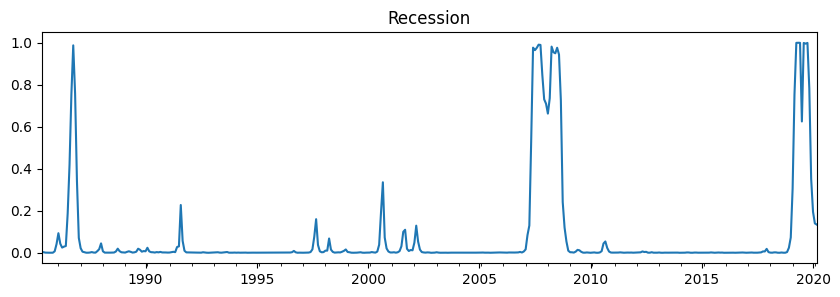

In [8]:
import matplotlib.pyplot as plt

# Create a new DataFrame to store the ratios
date_range_ratios = pd.date_range(start='1986-04', end='2021-03', freq='M')
df_ratios = pd.DataFrame({'date': date_range_ratios, 'ratio': recession.ravel()})
df_ratios.set_index('date', inplace=True)

# Plot the ratio series and capture the ax object
ax = df_ratios['ratio'].plot(title="Recession", figsize=(10, 3))

ticks = pd.date_range('1990-01-01', '2025-01-01', freq='5Y')
plt.xticks(ticks, ticks.strftime('%Y'))

# Remove the x-axis label
ax.set_xlabel('')

output_filepath = "recession_plot.png"
plt.savefig(output_filepath, format='png', dpi=300, bbox_inches='tight')

plt.show()

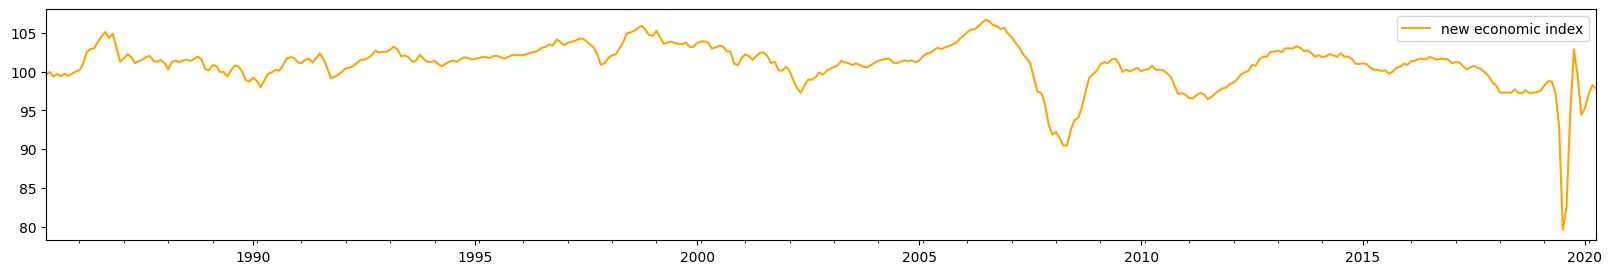

In [9]:
import numpy as np
from numpy.random import normal
N=kalpre.shape[0]
ddelta=np.mean(delta)
C0=99
newCLI = np.zeros((N, 1))
dddelta=np.mean(delta)
newCLI[0]=C0+(sample_ct/(iter-burn))[0]+dddelta
for i in range(1, N):
    newCLI[i] = newCLI[i-1] + (sample_ct/(iter-burn))[i]+dddelta # new delta_C_t=delta_c_t+C_{t-1}+delta according to appendix A7
    # Create an array of monthly dates
newCLI=newCLI[1:N]
dates = pd.date_range(start='1986-04', end='2021-03', freq='MS')

# Create a pandas Series with the data and the dates as index
series1 = pd.Series(data=newCLI.ravel(), index=dates)
fig, ax = plt.subplots(figsize=(20,3))
# Plot the series
series1.plot(figsize=(20,3), legend=False,label='new economic index',color='orange')

ticks = pd.date_range('1990-01-01', '2025-01-01', freq='5Y')
plt.xticks(ticks, ticks.strftime('%Y'))
# Set the y-axis limits

plt.legend()
plt.savefig('myplot.png')
plt.show()

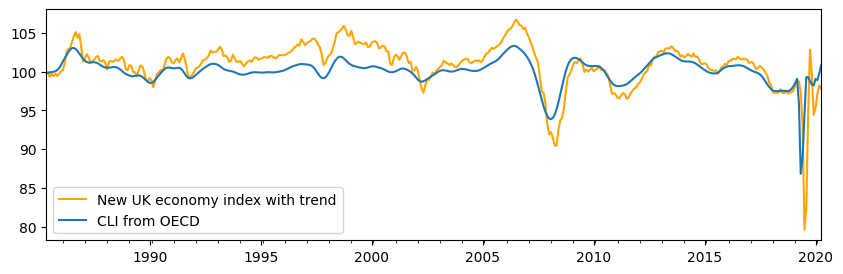

In [10]:
import os
import pandas as pd
import numpy as np
url = 'https://raw.githubusercontent.com/Buchunwang/UK-CLI/main/Kalman%20filter/CLI_raw.csv'#original CLI data
CLI = pd.read_csv(url, header=None, encoding='utf-8', skiprows=1)
# Create an array of monthly dates
dates = pd.date_range(start='1986-04-01', end='2021-3-01', freq='MS')

# Create a pandas Series with the data and the dates as index
series1 = pd.Series(data=newCLI.ravel(), index=dates)
fig, ax = plt.subplots(figsize=(10,3))
# Plot the series
series1.plot(figsize=(10,3), legend=False,label='New UK economy index with trend',color='orange')

# Create another pandas Series with the same dates as index
series2 = pd.Series(CLI[1:].values.ravel(), index=dates)
# Plot the series

# Plot the second series
series2.plot(figsize=(10,3), legend=False,label='CLI from OECD')

ticks = pd.date_range('1990-01-01', '2025-01-01', freq='5Y')
plt.xticks(ticks, ticks.strftime('%Y'))


# Set the y-axis limits
#ax.set_ylim(80, 110)
plt.legend()
plt.savefig('new_index.png')
plt.show()